In [20]:
import pandas as pd

df = pd.read_excel("../data/Customer Data.xlsx")
display(df.head())
df.info()

,Customer ID,Booking ID,Hotel,Booking Date,Arrival Date,Lead Time,Nights,Guests,Distribution Channel,Customer Type,Country,Deposit Type,Avg Daily Rate,Status,Status Update,Cancelled (0/1),Revenue,Revenue Loss
0,CS5295,1,Resort,2014-07-24,2015-07-01,342,0,2,Direct,Transient,Portugal,No Deposit,0.0,Check-Out,2015-07-01,0,0.0,0.0
1,CS4768,2,Resort,2013-06-24,2015-07-01,737,0,2,Direct,Transient,Portugal,No Deposit,0.0,Check-Out,2015-07-01,0,0.0,0.0
2,CS2122,3,Resort,2015-06-24,2015-07-01,7,1,1,Direct,Transient,United Kingdom,No Deposit,75.0,Check-Out,2015-07-02,0,75.0,0.0
3,CS1217,4,Resort,2015-06-18,2015-07-01,13,1,1,Corporate,Transient,United Kingdom,No Deposit,75.0,Check-Out,2015-07-02,0,75.0,0.0
4,CS1850,5,Resort,2015-06-17,2015-07-01,14,2,2,Online Travel Agent,Transient,United Kingdom,No Deposit,98.0,Check-Out,2015-07-03,0,196.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Customer ID           119390 non-null  object        
 1   Booking ID            119390 non-null  int64         
 2   Hotel                 119390 non-null  object        
 3   Booking Date          119390 non-null  datetime64[ns]
 4   Arrival Date          119390 non-null  datetime64[ns]
 5   Lead Time             119390 non-null  int64         
 6   Nights                119390 non-null  int64         
 7   Guests                119390 non-null  int64         
 8   Distribution Channel  119390 non-null  object        
 9   Customer Type         119390 non-null  object        
 10  Country               118902 non-null  object        
 11  Deposit Type          119390 non-null  object        
 12  Avg Daily Rate        119390 non-null  float64       
 13 

In [21]:
snapshot_date = df['Arrival Date'].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date)
rfm_df = df.groupby('Customer ID').agg({
    'Arrival Date': lambda x: (snapshot_date - x.max()).days,   
    'Booking ID': 'count',                                       
    'Revenue': 'sum'                                             
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

display(rfm_df.head())


Snapshot date: 2017-09-01 00:00:00


,CustomerID,Recency,Frequency,Monetary
0,CS1112,109,15,4317.16
1,CS1113,1,20,5078.32
2,CS1114,21,19,3892.70
3,CS1115,11,22,2986.50
4,CS1116,44,13,3425.78


In [22]:


r_labels = range(4, 0, -1)  
f_labels = m_labels = range(1, 5)  

rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 4, labels=r_labels)
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method="first"), 4, labels=f_labels)
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'].rank(method="first"), 4, labels=m_labels)


rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)


display(rfm_df.head())


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,CS1112,109,15,4317.16,1,2,3,123
1,CS1113,1,20,5078.32,4,3,3,433
2,CS1114,21,19,3892.70,3,3,2,332
3,CS1115,11,22,2986.50,4,3,1,431
4,CS1116,44,13,3425.78,2,1,2,212


In [ ]:
import numpy as np


rfm_df['Recency_sqrt'] = np.sqrt(rfm_df['Recency'])
rfm_df['Frequency_sqrt'] = np.sqrt(rfm_df['Frequency'])
rfm_df['Monetary_sqrt'] = np.sqrt(rfm_df['Monetary'])


X = rfm_df[['Recency_sqrt', 'Frequency_sqrt', 'Monetary_sqrt']]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


X = rfm_df[['Recency_sqrt', 'Frequency_sqrt', 'Monetary_sqrt']]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(X_scaled)


display(rfm_df.head())


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Recency_sqrt,Frequency_sqrt,Monetary_sqrt,Cluster
0,CS1112,109,15,4317.16,1,2,3,123,10.440307,3.872983,65.705099,2
1,CS1113,1,20,5078.32,4,3,3,433,1.000000,4.472136,71.262332,1
2,CS1114,21,19,3892.70,3,3,2,332,4.582576,4.358899,62.391506,1
3,CS1115,11,22,2986.50,4,3,1,431,3.316625,4.690416,54.648879,1
4,CS1116,44,13,3425.78,2,1,2,212,6.633250,3.605551,58.530163,3


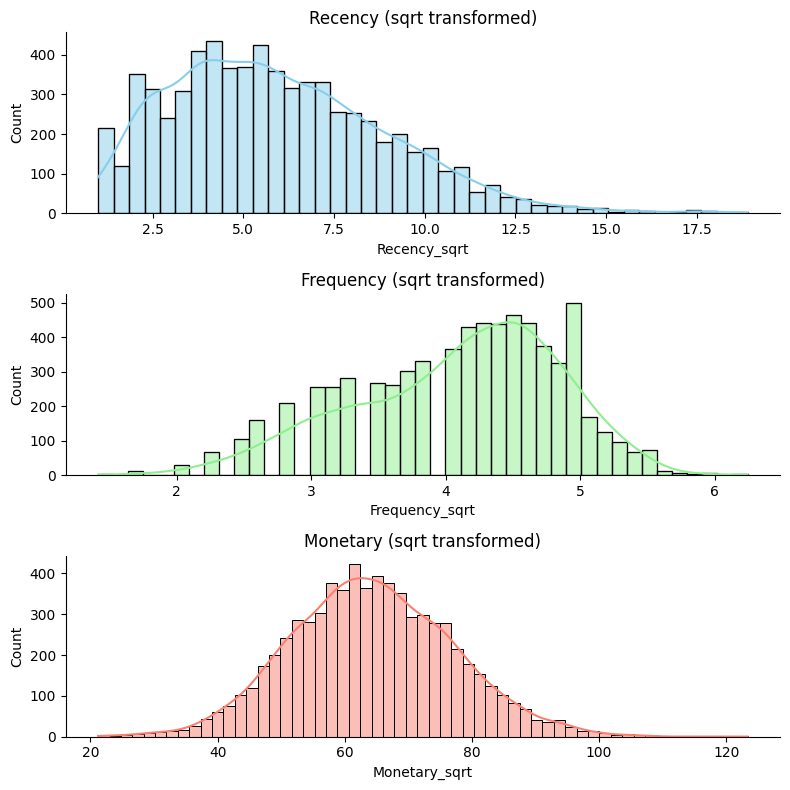

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(3, 1, figsize=(8, 8))
sns.despine(left=False, bottom=False)


sns.histplot(rfm_df['Recency_sqrt'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Recency (sqrt transformed)')

sns.histplot(rfm_df['Frequency_sqrt'], kde=True, ax=ax[1], color='lightgreen')
ax[1].set_title('Frequency (sqrt transformed)')

sns.histplot(rfm_df['Monetary_sqrt'], kde=True, ax=ax[2], color='salmon')
ax[2].set_title('Monetary (sqrt transformed)')

plt.tight_layout()
plt.show()


In [26]:

cluster_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
cluster_counts = rfm_df['Cluster'].value_counts().sort_index()


cluster_summary['Num_Customers'] = cluster_counts

display(cluster_summary)


,Recency,Frequency,Monetary,Num_Customers
Cluster,,,,
0,31.91,23.29,6311.69,1830
1,18.18,16.95,4027.19,2065
2,98.22,18.04,3743.63,1631
3,35.30,9.05,2661.92,1363


In [27]:

cluster_labels = {
    0: 'Champions',     
    1: 'At Risk',         
    2: 'Loyal Customers', 
    3: 'Need Attention'   
}

rfm_df['Segment'] = rfm_df['Cluster'].map(cluster_labels)
display(rfm_df[['CustomerID', 'Cluster', 'Segment']].head())


,CustomerID,Cluster,Segment
0,CS1112,2,Loyal Customers
1,CS1113,1,At Risk
2,CS1114,1,At Risk
3,CS1115,1,At Risk
4,CS1116,3,Need Attention


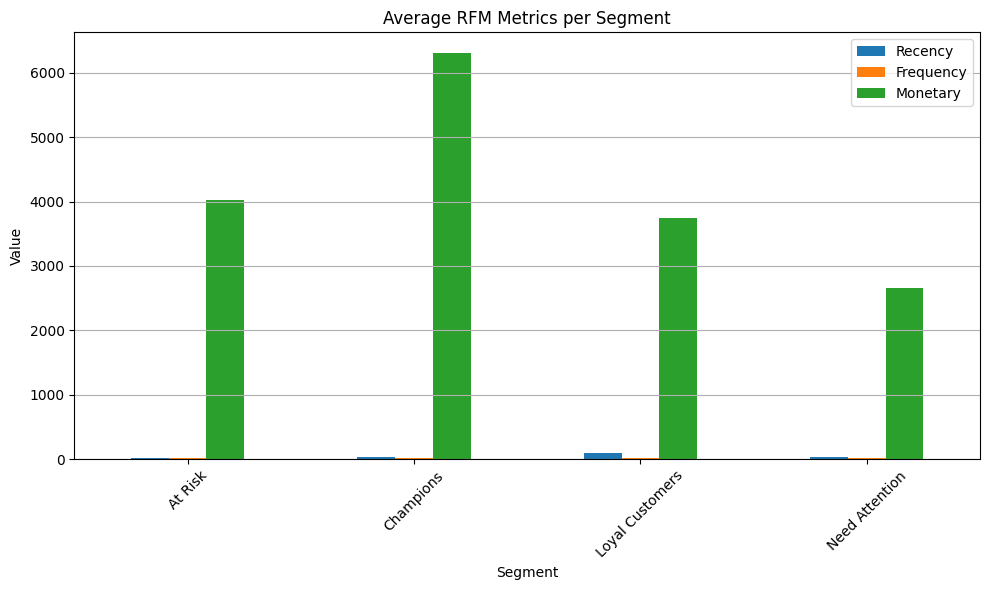

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot average RFM values by segment
cluster_summary = rfm_df.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean().round(1)

cluster_summary.plot(kind='bar', figsize=(10,6))
plt.title('Average RFM Metrics per Segment')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
